In [1]:
import serial
import time
import numpy as np


In [2]:
from pygame import mixer  # Load the popular external library

mixer.init()
mixer.music.load("1khz.mp3")

pygame 2.1.2 (SDL 2.0.18, Python 3.10.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
!adb devices

List of devices attached
R52RB0D7XMM	device



In [4]:
import subprocess
import math
import numpy as np
%matplotlib widget
from matplotlib import pyplot as plt
from matplotlib.path import Path

In [5]:

cmd = r'adb shell wm size'

p1=subprocess.Popen(cmd,shell=True,stdout=subprocess.PIPE)
for line in p1.stdout:
    print(line)
    line = line.decode(encoding="utf-8", errors="ignore")
    line = line.strip()
    if 'Physical size' in line:
        wm_size = (np.array(line.split(' ')[-1].split('\r\n')[0].split('x')).astype(int))
        break
        
wm_center = (wm_size[0]//2, wm_size[1]//2)
wm_size, wm_center

b'Physical size: 1600x2560\r\n'


(array([1600, 2560]), (800, 1280))

Check everything works

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
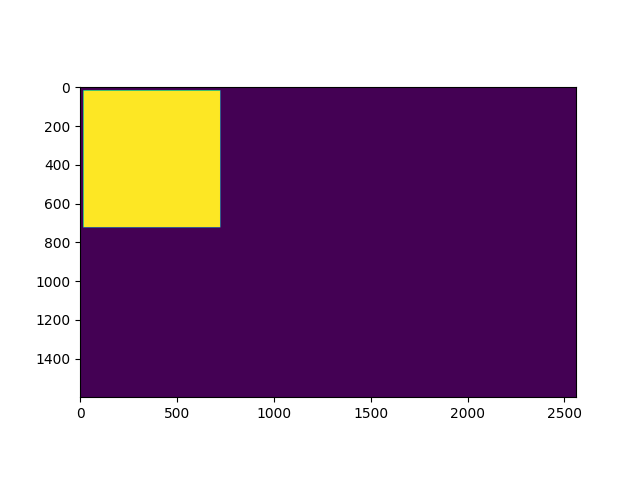

In [6]:
def gen_mask(num_verts, figure_radius, figure_center, first_angle, wm_size):
    

    
    angles = [[np.cos(theta), np.sin(theta)] 
              for theta in np.linspace(first_angle, 
                                       first_angle+2*np.pi, 
                                       num_verts+1)]

    verts = np.array(angles)*figure_radius + figure_center

    polygon=verts
    poly_path=Path(polygon)

    x, y = np.mgrid[:wm_size[0], :wm_size[1]]
    coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1))) # coors.shape is (4000000,2)

    mask = poly_path.contains_points(coors).reshape(wm_size[0], wm_size[1])
    
    return mask, verts

figure_mask, verts = gen_mask(num_verts=4,
                       figure_radius=500,
                       figure_center=370, 
                       first_angle=np.pi/4,
                       wm_size=wm_size)

plt.figure()
plt.imshow((figure_mask))
plt.show()

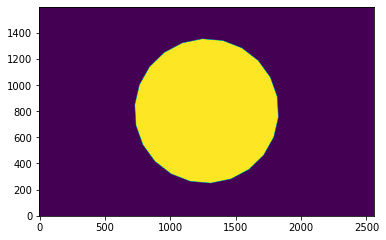

In [10]:
%matplotlib inline

#Choose randomly number of vertex 
num_verts=np.random.choice([4,5,22])
figure_radius=550
figure_center=wm_center 

#Choose randomly number of vertex 
first_angle= np.random.rand() * np.pi
# first_angle = np.pi/4
wm_size=wm_size

figure_mask, figure_verts = gen_mask(num_verts,
                       figure_radius,
                       figure_center,
                       first_angle,
                       wm_size)

plt.figure()
plt.imshow((figure_mask))
plt.gca().invert_yaxis()

In [11]:

current_stim_group = np.random.choice([0])
# 0 - a 1 - b 
peak_amp      = [ 10][current_stim_group]
baseline_stim = [ 4][current_stim_group]
stim_amp      = peak_amp - baseline_stim

print(['A'][current_stim_group], baseline_stim, stim_amp)

current_stim_group='audio'

A 4 6


In [12]:
current_stim_group

'audio'

22-04-02_18-24-03


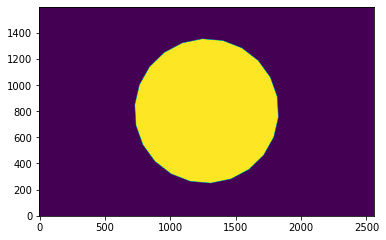

sss


KeyboardInterrupt: 

In [13]:
from datetime import datetime as dt
import os
import subprocess


time_label = dt.now().strftime('%y-%m-%d_%H-%M-%S')
print(time_label)

plt.figure()
plt.imshow((figure_mask))
plt.gca().invert_yaxis()
plt.savefig(os.path.join('session', time_label + '_figure_mask.png'), dpi=300)
plt.show()
session_log_filename = os.path.join('session', time_label + '_session.log')

x, y = 0, 0
cmd = r'adb shell getevent -t /dev/input/event5'

toggle = 0;
toggle_prev = 0;
p1=subprocess.Popen(cmd,shell=True,stdout=subprocess.PIPE)

print('sss')

with open(session_log_filename, 'w+') as f:
    f.write('Mode = area stim')
    f.write(f'''
    verts = {num_verts} 
    radius = {figure_radius} 
    center = {figure_center} 
    first_angle = {first_angle} 
    wm_size = {wm_size} 
    stim_amp = {stim_amp} 
    baseline_stim = {baseline_stim}
    current_stim_group = {current_stim_group}
    sense_zone = {0}
    ===============================\n''')
    for l in p1.stdout:
        line = l.decode(encoding="utf-8", errors="ignore").strip()
        
        #print(line)

        if ' 0036 ' in line:
            e = line.split(" ")
            x = e[-1]
            x = int(x, 16)
            #print(x) # 0 -- 900, но длинная стороны
            if (y > 0) & (x>0):
                
                #For tpad
                #x_phys = int(np.round(x/800*1920))
                #y_phys = int(np.round(y/1280*1200))
                #print(str((x_phys,y_phys)))
                
                #For Samsung
                x_phys = x
                y_phys = y
                
                
                toggle = figure_mask[y_phys, x_phys]
                f.write(str(dt.now()) + ' ' + str(toggle) + ' ' + str(line) + '\n')

        if  ' 0035 ' in line:
            e = line.split(" ")
            y = e[-1]
            y = int(y, 16)
            #print(y)
            if (y > 0) & (x>0):
                p = (x, y)    
                
                #For tpad
                #x_phys = int(np.round(x/800*1920))
                #y_phys = int(np.round(y/1280*1200))
                #print(str((x_phys,y_phys)))
                
                #For Samsung
                x_phys = x
                y_phys = y
                
                toggle = figure_mask[y_phys, x_phys]
                rev = toggle
                    #slides[current_stim_group].set_value(toggle*stim_amp+baseline_stim)
                    
                #print(f'{x:04d}, {y:04d} {toggle}', line, end='\r')
                f.write(str(dt.now()) + ' ' + str(toggle) + ' ' + str(line) + '\n')
    
                if toggle!=toggle_prev:
                    # print(str(toggle)+'   '+str(x)+'     '+str(y), end='\r');
                    toggle_prev=toggle
                    #st=toggle*stim_amp+baseline_stim
                    
                    if toggle:
                        mixer.music.play()
                    else:
                        mixer.music.stop()
                    
                    while p1.stdout.tell() < -200:
                        p1.stdout.readline()
                

In [ ]:
mixer.music.play()

In [15]:
mixer.music.stop()

In [ ]:
p1=subprocess.Popen(cmd,shell=True,stdout=subprocess.PIPE)

In [14]:
mm.StopDevice()

NameError: name 'mm' is not defined

In [ ]:
cmd = r'adb shell getevent -t /dev/input/event2'

In [ ]:
for l in p1.stdout:
    line = l.decode(encoding="utf-8", errors="ignore").strip()
    print(line)

In [ ]:
p1.stdout:

In [ ]:
from datetime import datetime as dt
import os
import subprocess


time_label = dt.now().strftime('%y-%m-%d_%H-%M-%S')
print(time_label)

plt.figure()
plt.imshow((figure_mask))
plt.gca().invert_yaxis()
plt.savefig(os.path.join('session', time_label + '_figure_mask.png'), dpi=300)
plt.show()
session_log_filename = os.path.join('session', time_label + '_session.log')

x, y = 0, 0
cmd = r'adb shell getevent -t /dev/input/event5'

toggle = 0;
toggle_prev = 0;
p1=subprocess.Popen(cmd,shell=True,stdout=subprocess.PIPE)

print('sss')

with open(session_log_filename, 'w+') as f:
    f.write('Mode = area stim')
    f.write(f'''
    verts = {num_verts} 
    radius = {figure_radius} 
    center = {figure_center} 
    first_angle = {first_angle} 
    wm_size = {wm_size} 
    stim_amp = {stim_amp} 
    baseline_stim = {baseline_stim}
    current_stim_group = {current_stim_group}
    sense_zone = {0}
    ===============================\n''')
    for l in p1.stdout:
        line = l.decode(encoding="utf-8", errors="ignore").strip()
        
        #print(line)

        if ' 0036 ' in line:
            e = line.split(" ")
            x = e[-1]
            x = int(x, 16)
            #print(x) # 0 -- 900, но длинная стороны
            if (y > 0) & (x>0):
                
                #For tpad
                x_phys = int(np.round(x/800*1920))
                y_phys = int(np.round(y/1280*1200))
                
                
                #print(str((x_phys,y_phys)))
                #toggle = figure_mask[y_phys, x_phys]
                f.write(str(dt.now()) + ' ' + str(toggle) + ' ' + str(line) + '\n')

        if  ' 0035 ' in line:
            e = line.split(" ")
            y = e[-1]
            y = int(y, 16)
            #print(y)
            if (y > 0) & (x>0):
                p = (x, y)    
                print(y)
                x_phys = int(np.round(x/800*1920))
                y_phys = int(np.round(y/1280*1200))
                #print(str((x_phys,y_phys)))
                #toggle = figure_mask[y_phys, x_phys]
                rev = toggle
                    #slides[current_stim_group].set_value(toggle*stim_amp+baseline_stim)
                    